Here are some nice plots and animation :)


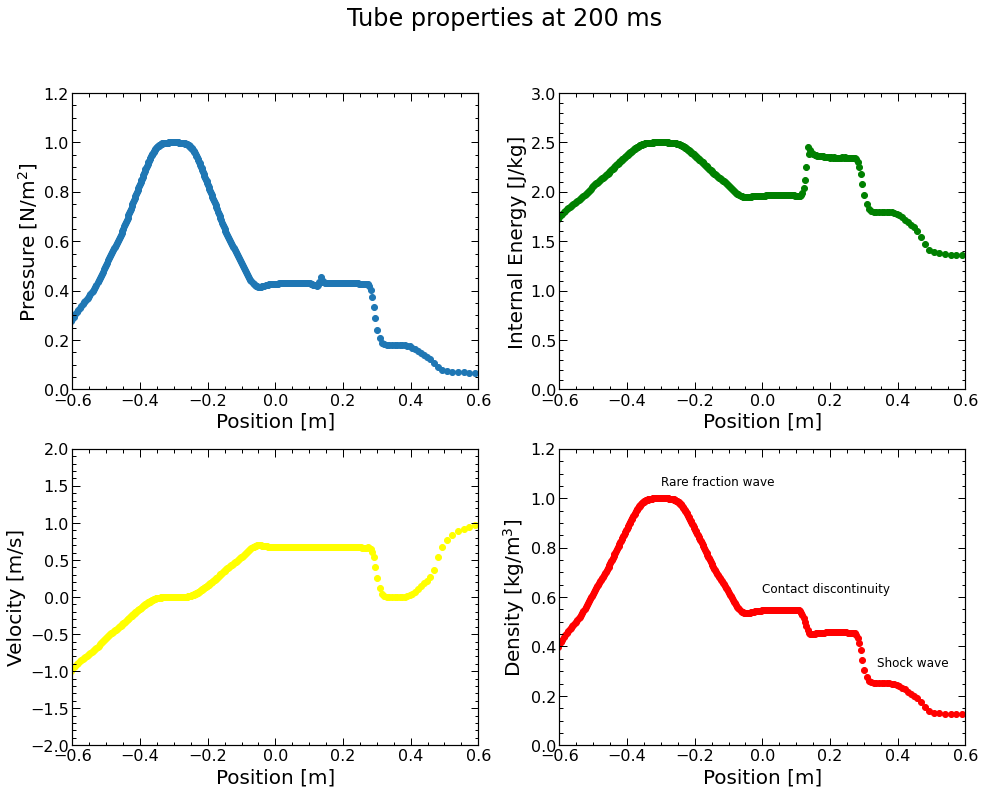

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from array import *
import random
from scipy import *
from scipy.spatial.distance import pdist
import numpy as np
from matplotlib import cm, colors, pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import copy
import ffmpeg
from mpl_toolkits.mplot3d import Axes3D
from time import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

plt.style.use('presentation-Copy1.mplstyle')

# Properties for the integrator
time_step   = 0.005
steps       = 41 # Number of steps to integrate

def Smooth(x,h):
    kappa = 2
    H = (h + h[:,np.newaxis])/2
    alpha = 1/H
    sl = kappa*H
    dx = x - x[:,np.newaxis]
    r = np.abs(dx)
    R = r/H
 
    W = np.zeros(r.shape)
    dW = np.zeros(r.shape)
    # print('dx',dx.shape, 'r',r.shape, 'R',R.shape, 'W',W.shape, 'dW',dW.shape)

    # Conditions for kernel function
    R1 = (r < H) & (R >= 0) # since R = |dx|/h < 1 --> |dx| < h
    R2 = (H <= r) & (r < 2*H) # Since R = |dx|/h < 2 --> |dx| < 2*h  
    
    # solve equation with conditions
    W[R1] = (2/3) - (R[R1]**2) + (1/2)*(R[R1]**3)
    W[R2] = (1/6)*(2- R[R2])**3
 
    dW[R1] = (-2 + (3/2)*R[R1]) * (dx[R1])/(H[R1]**2)
    dW[R2] = - (1/2)*((2 - R[R2])**2) * (dx[R2])/(H[R2]*r[R2])
    dW[R2] = np.nan_to_num(dW[R2])
 
    val_W = alpha*W
    val_dW = alpha*dW
    return val_W, val_dW, H


def Derivatives(t, r, boundary = False):
    '''This function calculates the evolution of the properties: Density, pressure, position, internal energy
    and velocity for the particles. The state vector r is evolved using an inbuilt integrator the solves
    the coupled ODEs, given as the co-moving derivatives in the Navier stokes equations.
    If you want to include no-slip boundary condition, set boundary = True'''
    
    # Constants
    N = 400
    gamma = 1.4
    eta = 1.2

    # What is to be solved: State vector
    x = np.array(r[:N])
    P = np.array(r[N:2*N])
    rho = np.array(r[2*N:3*N])
    v = np.array(r[3*N:4*N])
    e = np.array(r[4*N:5*N])
    c = r[5*N:6*N]
    m = r[6*N:7*N]

    h = np.ones(len(rho))*0.01 # Use for more stable solution
    #h = eta*(m/rho) # Variable smoothinglength
    hij = (1/2)*(h + h[:, np.newaxis])
    
    # Kernel function values
    W, dW, DX = Smooth(x, h) # dx = velocity derivative
    
    # Density
    sum_dens = m[:, np.newaxis]*W
    rho = np.sum(sum_dens, axis = 0)
    
    # Pressure 
    P = (gamma-1)*rho*e
    
    # Update state vector
    r[N:2*N] = P
    r[2*N:3*N] = rho

        
    # Viscosity equations
    phiij = 0.1*hij
    
    c = np.sqrt((gamma-1)*e)
    c = np.nan_to_num(c)
    cij= 0.5*(c + c[:,np.newaxis])
    
    vij = v - v[:, np.newaxis]
    xij = x - x[:, np.newaxis]
    
    rhoij = 0.5*(rho + rho[:, np.newaxis])
    cond = vij*xij

    PIij = np.zeros(vij.shape)
    
    # Conditions for largepi 
    cond1 = (cond < 0)
    cond2 = (cond >= 0)

    varphiij = (hij*vij*xij)/((np.abs(xij)**2) + phiij**2)
    
    PIij[cond1] = (-cij[cond1]*varphiij[cond1] + varphiij[cond1]**2)/(rhoij[cond1])
    PIij[cond2] = 0

    largepi = PIij

    # i and j values of pressure and density
    PI = P
    PJ = P[:, np.newaxis]
    rhoi = rho
    rhoj = rho[:, np.newaxis]

    pressure_and_density_fraction = ((PI/(rhoi**2)) + (PJ/(rhoj**2)) + largepi)*m[:, np.newaxis]
    
    # Acceleration
    dv_calc = -pressure_and_density_fraction*dW
    dv = np.sum(dv_calc, axis=0)
    
    # Dirichlet no-slip boundary condition
    if boundary:
        Z1 = (-0.6 >= x)                     
        Z2 = (x >= 0.6)                    

        dv[Z1] = 0            
        dv[Z2] = 0
        #dv[Z1] = np.abs(dv[Z1])
        #dv[Z2] = -np.abs(dv[Z2])
    
    # Energy 
    de_calc = (m[:, np.newaxis])*(PI/(rhoi**2) + PJ/(rhoj**2) + largepi)*vij*dW
    de = 0.5*np.sum(de_calc, axis = 0)
    
    # velocity
    dxx = v
    
    # Derivatives 
    drho = np.zeros(N)
    dP = np.zeros(N)
    dm = np.zeros(N)
    dc = np.zeros(N)
    
    Wu = np.hstack((dxx, dP, drho, dv, de, dc, dm))

    return Wu

# init positions
pdist = 0.001875
p2dist = 0.0075
first_int = np.arange(-0.6,0,pdist) # List of particles in first interval
sec_int = np.arange(0.0075,0.6+0.0075,p2dist) # List of particles in second interval

mat = np.zeros(400)
mat[:320] = first_int
mat[320:] = sec_int

# init Pressure
matp = np.zeros(400)
matp[:320] = 1
matp[320:] = 0.1795

# init density
matrho = np.zeros(400)
matrho[:320] = 1
matrho[320:] = 0.25

# init velocity
matv = np.zeros(400)
matv[:320] = 0
matv[320:] = 0

# init energy
mate = np.zeros(400)
mate[:320] = 2.5
mate[320:] = 1.795

# init mass
matm = np.zeros(400)
matm[:] = 0.001875

# init c
matc = np.zeros(400)

# Initial values for integrator
s0   = np.hstack((mat, matp, matrho, matv, mate, matc, matm))

# Time evaluation
time = np.arange(0, steps*time_step, time_step)

# Solve integration
s    = solve_ivp(Derivatives, [0,steps*time_step], s0, t_eval=time)

# Properties obtained from integration
t       = s.t
N       = 400
pos     = s.y[:N]
pres    = s.y[N:2*N]
dens    = s.y[2*N:3*N]
vel     = s.y[3*N:4*N]
en      = s.y[4*N:5*N]
mas     = s.y[6*N:7*N]
gamma   = 1.4
P       = (gamma-1)*dens*en

def updateplotting(pres, velo, densi, energ):
    '''This function plots the various quantities and an updating manner. Set the input parameters
    to True if wanting the plot.'''
    
    if pres:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Pressure [W/m2]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], P[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()

    if energ:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Internal Energy [J/kg]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], en[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
            
    if velo:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Velocity [m/s]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], vel[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
        
    if densi:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Pressure [W/m2]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], dens[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
    return 
#print(updateplotting(pres = True, velo = True, densi = True, energ = True))

def subplotting(pres, velo, densi, energ):
    '''This function plots the various quantities.'''
    for i in range(steps):
        if i ==40: # can use i % x == 0 to update subplots, where x is some number in the interval [0, steps]
            fig = plt.figure(figsize = (16,12))
            plt.suptitle('Tube properties at {} ms'.format(5*i))
            plt.subplot(221)
            plt.ylim(0,1.2)
            plt.xlabel('Position [m]')
            plt.ylabel(r'Pressure [N/m$^2$]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], P[:, i], label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(222)
            plt.ylim(0,3)
            plt.xlabel('Position [m]')
            plt.ylabel('Internal Energy [J/kg]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], en[:, i], color = 'green', label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(223)
            plt.ylim(-2,2)
            plt.xlabel('Position [m]')
            plt.ylabel('Velocity [m/s]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], vel[:, i], color = 'yellow',label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(224)
            plt.text(-0.3, 1.05, 'Rare fraction wave', fontsize = 12)
            plt.text(0,0.62, 'Contact discontinuity', fontsize = 12)
            plt.text(0.34, 0.32, 'Shock wave', fontsize = 12)
            plt.ylim(0,1.2)
            plt.xlabel('Position [m]')
            plt.ylabel(r'Density [kg/m$^3$]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], dens[:, i], color = 'red',label = 'Time = {} ms'.format(i*5))
            plt.savefig('tube_at_40ms_w_labels.png', dpi = 300, bbox_inches = 'tight')

    return 'Here are some nice plots and animation :)'
print(subplotting(pres = True, velo = True, densi = True, energ = True))


'''ANIMTATION'''
fig, ax = plt.subplots(figsize=(8, 8)) #Determines size of figure
ax = plt.axes(xlim=(-0.6, 0.6), ylim = (-2,3))
lineP, = ax.plot([], [], 'bo', label = r'Pressure [N/m$^2$]')
linerho, = ax.plot([], [], 'ro', label = r'Density [kg/m$^3$]' )
lineen, = ax.plot([], [], 'go' , label = r'Energy [J/kg]')
linevel, = ax.plot([], [], 'yo', label = r'Velocity [m/s]')
plt.grid()
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.legend(loc = 4, fontsize = 14)

def init():
    lineP.set_data([], [])
    linerho.set_data([], [])
    lineen.set_data([],[])
    linevel.set_data([],[])
    return lineP, linerho, lineen, linevel


def animate(i):
    tid = 5*i
    
    xP = pos[:, i]
    yP = P[:, i]
    lineP.set_data(xP, yP)
    
    yrho = dens[:, i]
    linerho.set_data(xP, yrho)
    
    yen = en[:, i]
    lineen.set_data(xP, yen)
    
    yvel = vel[:, i]
    linevel.set_data(xP, yvel)
    
    time_text.set_text('Time = %.1f ms' % tid)
    return lineP, linerho, lineen, linevel

'''Animation, comment these lines if you don't want to animate'''
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=40, blit=True)
plt.draw()
plt.close(fig)
HTML(anim.to_html5_video())
#anim.save('animation_2s_tube.mp4', writer='ffmpeg', fps=30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from array import *
import random
from scipy import *
from scipy.spatial.distance import pdist
import numpy as np
from matplotlib import cm, colors, pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import copy
import ffmpeg
from mpl_toolkits.mplot3d import Axes3D
from time import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

plt.style.use('presentation-Copy1.mplstyle')

# Properties for the integrator
time_step   = 0.005
steps       = 81 # Number of steps to integrate

def Smooth(x,h):
    kappa = 2
    H = (h + h[:,np.newaxis])/2
    alpha = 1/H
    sl = kappa*H
    dx = x - x[:,np.newaxis]
    r = np.abs(dx)
    R = r/H
 
    W = np.zeros(r.shape)
    dW = np.zeros(r.shape)
 
    # Conditions for kernel function
    R1 = (r < H) & (R >= 0) # since R = |dx|/h < 1 --> |dx| < h
    R2 = (H <= r) & (r < 2*H) # Since R = |dx|/h < 2 --> |dx| < 2*h  
    
    # solve equation with conditions
    W[R1] = (2/3) - (R[R1]**2) + (1/2)*(R[R1]**3)
    W[R2] = (1/6)*(2- R[R2])**3
 
    dW[R1] = (-2 + (3/2)*R[R1]) * (dx[R1])/(H[R1]**2)
    dW[R2] = - (1/2)*((2 - R[R2])**2) * (dx[R2])/(H[R2]*r[R2])
    dW[R2] = np.nan_to_num(dW[R2])
 
    val_W = alpha*W
    val_dW = alpha*dW

    return val_W, val_dW, H


def Derivatives(t, r, boundary = False):
    '''This function calculates the evolution of the properties: Density, pressure, position, internal energy
    and velocity for the particles. The state vector r is evolved using an inbuilt integrator the solves
    the coupled ODEs, given as the co-moving derivatives in the Navier stokes equations.
    If you want to include no-slip boundary condition, set boundary = True'''
    
    # Constants
    N = 400
    gamma = 1.4
    eta = 1.2

    # What is to be solved: State vector
    x = np.array(r[:N])
    y = np.array(r[N:2*N])
    z = np.array(r[2*N:3*N])
    P = np.array(r[3*N:4*N])
    rho = np.array(r[4*N:5*N])
    v = np.array(r[5*N:6*N])
    vy = np.array(r[6*N:7*N])
    vz = np.array(r[7*N:8*N])
    e = np.array(r[8*N:9*N])
    c = r[9*N:10*N]
    m = r[10*N:11*N]

    #h = np.ones(len(rho))*0.01 # Use for more stable solution
    h = eta*(m/rho) # Variable smoothinglength
    hij = (1/2)*(h + h[:, np.newaxis])
    
    # Kernel function values
    W, dW, DX = Smooth(x, h) # dx = velocity derivative
    
    # Density
    sum_dens = m[:, np.newaxis]*W
    rho = np.sum(sum_dens, axis = 1)
    
    # Pressure 
    P = (gamma-1)*rho*e
    
    # Update state vector
    r[3*N:4*N] = P
    r[4*N:5*N] = rho

        
    # Viscosity equations
    phiij = 0.1*hij
    
    c = np.sqrt((gamma-1)*e)
    c = np.nan_to_num(c)
    cij= 0.5*(c + c[:,np.newaxis])
    
    vij = v - v[:, np.newaxis]
    xij = x - x[:, np.newaxis]
    
    rhoij = 0.5*(rho + rho[:, np.newaxis])
    cond = vij*xij

    PIij = np.zeros(vij.shape)
    
    # Conditions for largepi 
    cond1 = (cond < 0)
    cond2 = (cond >= 0)

    varphiij = (hij*vij*xij)/((np.abs(xij)**2) + phiij**2)
    
    PIij[cond1] = (-cij[cond1]*varphiij[cond1] + varphiij[cond1]**2)/(rhoij[cond1])
    PIij[cond2] = 0

    largepi = PIij

    # i and j values of pressure and density
    PI = P
    PJ = P[:, np.newaxis]
    rhoi = rho
    rhoj = rho[:, np.newaxis]

    pressure_and_density_fraction = ((PI/(rhoi**2)) + (PJ/(rhoj**2)) + largepi)*m[:, np.newaxis]
    
    # Acceleration
    dv_calc = -pressure_and_density_fraction*dW
    dv = np.sum(dv_calc, axis=0)
    
    # Dirichlet no-slip boundary condition
    if boundary:
        Z1 = (-0.6*0.95 >= x)                     
        Z2 = (x >= 0.6*0.95)                    

        dv[Z1] = 0            
        dv[Z2] = 0
        #dv[Z1] = np.abs(dv[Z1])
        #dv[Z2] = -np.abs(dv[Z2])
    
    # Energy 
    de_calc = (m[:, np.newaxis])*(PI/(rhoi**2) + PJ/(rhoj**2) + largepi)*vij*dW
    de = 0.5*np.sum(de_calc, axis = 0)
    
    # velocity
    dxx = v
    
    # Derivatives 
    drho = np.zeros(N)
    dP = np.zeros(N)
    dm = np.zeros(N)
    dc = np.zeros(N)
    
    Wu = np.hstack((dxx, y, z, dP, drho, dv,vy,vz, de, dc, dm))

    return Wu

# init positions
pdist = 0.001875
p2dist = 0.0075
first_int = np.arange(-0.6,0,pdist) # List of particles in first interval
sec_int = np.arange(0.0075,0.6+0.0075,p2dist) # List of particles in second interval

mat = np.zeros(400)
mat[:320] = first_int
mat[320:] = sec_int

# init Pressure
matp = np.zeros(400)
matp[:320] = 1
matp[320:] = 0.1795

maty = np.zeros(400)

matz = np.zeros(400)

# init density
matrho = np.zeros(400)
matrho[:320] = 1
matrho[320:] = 0.25

# init velocity
matv = np.zeros(400)
matv[:320] = 0
matv[320:] = 0

matvy = np.zeros(400)

matvz = np.zeros(400)

# init energy
mate = np.zeros(400)
mate[:320] = 2.5
mate[320:] = 1.795

# init mass
matm = np.zeros(400)
matm[:] = 0.001875

# init c
matc = np.zeros(400)

# Initial values for integrator
s0   = np.hstack((mat, maty, matz, matp, matrho, matv, matvy, matvz, mate, matc, matm))

# Time evaluation
time = np.arange(0, steps*time_step, time_step)

# Solve integration
s    = solve_ivp(Derivatives, [0,steps*time_step], s0, t_eval=time)

# Properties obtained from integration
t       = s.t
N       = 400
pos     = s.y[:N]
pres    = s.y[3*N:4*N]
dens    = s.y[4*N:5*N]
vel     = s.y[5*N:6*N]
en      = s.y[8*N:9*N]
mas     = s.y[10*N*N:11*N]
gamma   = 1.4
P       = (gamma-1)*dens*en

def updateplotting(pres, velo, densi, energ):
    '''This function plots the various quantities and an updating manner. Set the input parameters
    to True if wanting the plot.'''
    
    if pres:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Pressure [W/m2]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], P[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()

    if energ:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Internal Energy [J/kg]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], en[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
            
    if velo:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Velocity [m/s]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], vel[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
        
    if densi:
        for i in range(steps):
            if i % 10 == 0:
                plt.xlabel('Position [m]')
                plt.ylabel('Density [W/m2]')
                plt.xlim(-0.6,0.6)
                plt.scatter(pos[:, i], dens[:, i], label = 'Time = {} ms'.format(i))
                plt.legend()
                plt.figure()
    return 
#print(updateplotting(pres = False, velo = False, densi = True , energ = False))

def subplotting(pres, velo, densi, energ):
    '''This function plots the various quantities.'''
    for i in range(steps):
        if i ==40: # can use i % x == 0 to update subplots, where x is some number in the interval [0, steps]
            fig = plt.figure(figsize = (16,12))
            plt.suptitle('Tube properties at {} ms'.format(5*i))
            plt.subplot(221)
            plt.ylim(0,1.2)
            plt.xlabel('Position [m]')
            plt.ylabel(r'Pressure [N/m$^2$]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], P[:, i], label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(222)
            plt.ylim(0,3)
            plt.xlabel('Position [m]')
            plt.ylabel('Internal Energy [J/kg]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], en[:, i], color = 'green', label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(223)
            plt.ylim(-2,2)
            plt.xlabel('Position [m]')
            plt.ylabel('Velocity [m/s]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], vel[:, i], color = 'yellow',label = 'Time = {} ms'.format(i*5))
            
            plt.subplot(224)
            plt.text(-0.3, 1.05, 'Rare fraction wave', fontsize = 12)
            plt.text(0,0.62, 'Contact discontinuity', fontsize = 12)
            plt.text(0.34, 0.32, 'Shock wave', fontsize = 12)
            plt.ylim(0,1.2)
            plt.xlabel('Position [m]')
            plt.ylabel(r'Density [kg/m$^3$]')
            plt.xlim(-0.6,0.6)
            plt.scatter(pos[:, i], dens[:, i], color = 'red',label = 'Time = {} ms'.format(i*5))
            plt.savefig('tube_at_40ms_w_labels.png', dpi = 300, bbox_inches = 'tight')

    return 'Here are some nice plots and animation :)'
#print(subplotting(pres = True, velo = True, densi = True, energ = True))


'''ANIMTATION'''
fig, ax = plt.subplots(figsize=(8, 8)) #Determines size of figure
ax = plt.axes(xlim=(-0.6, 0.6), ylim = (-2,3))
lineP, = ax.plot([], [], 'bo', label = r'Pressure [N/m$^2$]')
linerho, = ax.plot([], [], 'ro', label = r'Density [kg/m$^3$]' )
lineen, = ax.plot([], [], 'go' , label = r'Energy [J/kg]')
linevel, = ax.plot([], [], 'yo', label = r'Velocity [m/s]')
plt.grid()
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.legend(loc = 4, fontsize = 14)

def init():
    lineP.set_data([], [])
    linerho.set_data([], [])
    lineen.set_data([],[])
    linevel.set_data([],[])
    return lineP, linerho, lineen, linevel


def animate(i):
    tid = 5*i
    
    xP = pos[:, i]
    yP = P[:, i]
    lineP.set_data(xP, yP)
    
    yrho = dens[:, i]
    linerho.set_data(xP, yrho)
    
    yen = en[:, i]
    lineen.set_data(xP, yen)
    
    yvel = vel[:, i]
    linevel.set_data(xP, yvel)
    
    time_text.set_text('Time = %.1f ms' % tid)
    return lineP, linerho, lineen, linevel

'''Animation, comment these lines if you don't want to animate'''
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=40, blit=True)
plt.draw()
plt.close(fig)
HTML(anim.to_html5_video())
#anim.save('animation_2s_tube.mp4', writer='ffmpeg', fps=30)

(2400,)
